In [1]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

visualize_data = True

In [2]:
import titanic_age_regression
import titanic_classifiers
import titanic_feature_creation
import titanic_feature_transformation
import titanic_plotting
import titanic_xgb_classifiers

# get titanic & test csv files as a DataFrame
titanic_df = pd.read_csv("../input/train.csv", dtype={"Age": np.float64}, )
test_df    = pd.read_csv("../input/test.csv", dtype={"Age": np.float64}, )

# preview the data
titanic_df.head()

/home/kyle/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
if visualize_data:
    titanic_df.info()
    print("----------------------------")
    test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare

In [4]:
titanic_df = titanic_feature_creation.create_title_classes(titanic_df)
test_df = titanic_feature_creation.create_title_classes(test_df)

Number of Mr.: 520 
Number of Mrs.: 126 
Number of Miss: 187 
Number of Dr.: 7 
Number of Master: 40 
Number of Reverends: 6 
Number of Military Officers: 5 
Total number of people: 891 
Number of Mr.: 240 
Number of Mrs.: 72 
Number of Miss: 80 
Number of Dr.: 1 
Number of Master: 21 
Number of Reverends: 2 
Number of Military Officers: 2 
Total number of people: 418 


In [5]:
# drop unnecessary columns, these columns won't be useful in analysis and prediction
titanic_df = titanic_df.drop(['PassengerId','Name','Ticket'], axis=1)
test_df    = test_df.drop(['Name','Ticket'], axis=1)

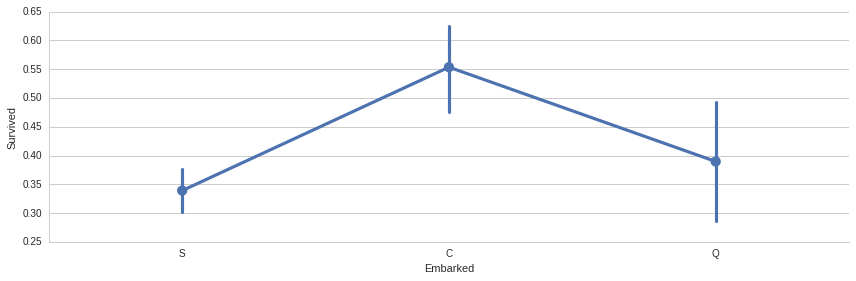

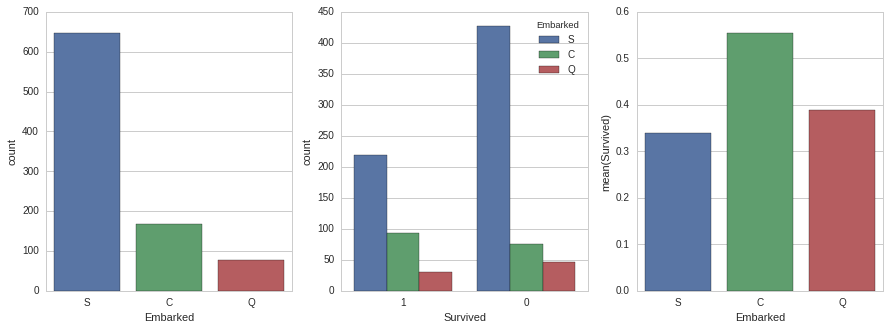

In [6]:
# Embarked

# only in titanic_df, fill the two missing values with the most occurred value, which is "S".
titanic_df["Embarked"] = titanic_df["Embarked"].fillna("S")

if visualize_data:
    titanic_plotting.make_embarked_survival_plot(titanic_df)
    
# Remove "S" dummy variable, 
# and leave "C" & "Q", since they seem to have a good rate for Survival.

titanic_df = titanic_feature_creation.one_hot_encode_embarked_variables(titanic_df)
test_df = titanic_feature_creation.one_hot_encode_embarked_variables(test_df)

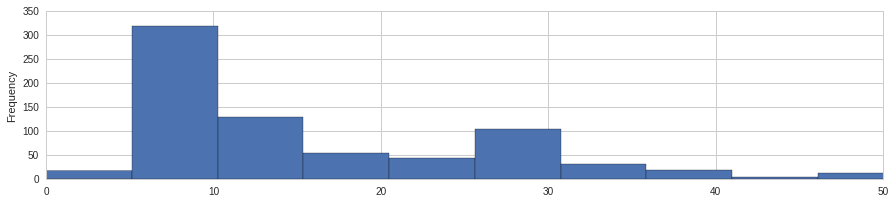

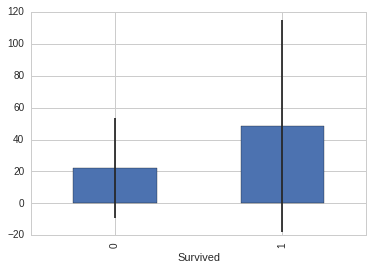

In [7]:
# Fare
for pclass in [1,2,3]:
    median_fare = pd.concat([titanic_df[titanic_df['Pclass']==pclass],test_df[test_df['Pclass']==pclass]])['Fare'].median()
    titanic_df.loc[(titanic_df['Pclass']==pclass) & (np.isnan(titanic_df["Fare"])),"Fare"] = median_fare
    test_df.loc[(test_df['Pclass']==pclass) & (np.isnan(test_df["Fare"])),"Fare"] = median_fare

if visualize_data:
    titanic_plotting.make_fare_plot(titanic_df)

In [8]:

titanic_df.drop("Cabin",axis=1,inplace=True)
test_df.drop("Cabin",axis=1,inplace=True)

titanic_df = titanic_feature_creation.one_hot_encode_gender_variables(titanic_df)
test_df = titanic_feature_creation.one_hot_encode_gender_variables(test_df)

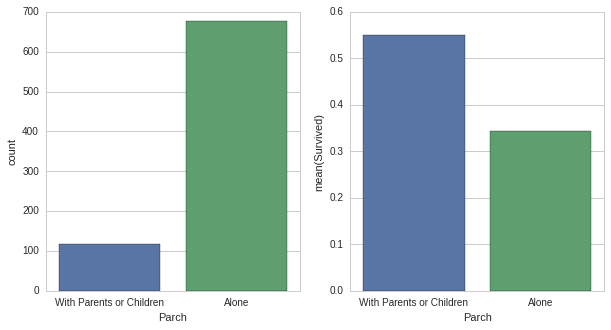

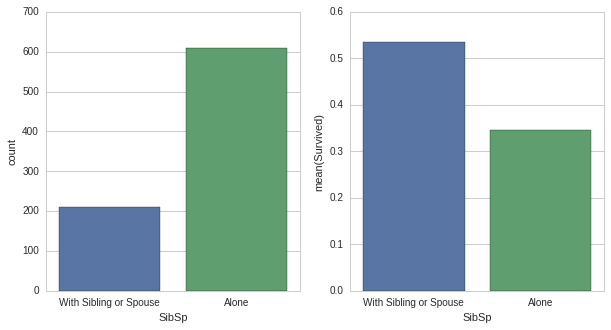

In [9]:
# Family
if visualize_data:
    titanic_plotting.make_parch_sibsp_survival_plots(titanic_df)


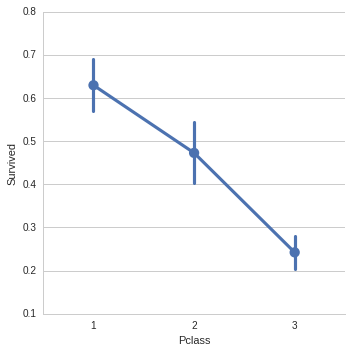

In [10]:
# Pclass
if visualize_data:
    titanic_plotting.make_class_survival_plot(titanic_df)

titanic_df = titanic_feature_creation.one_hot_encode_class_variables(titanic_df)
test_df = titanic_feature_creation.one_hot_encode_class_variables(test_df)


In [11]:
titanic_df = titanic_feature_creation.define_young_old_miss_features(titanic_df)
test_df = titanic_feature_creation.define_young_old_miss_features(test_df)

In [12]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import ShuffleSplit

# Age 

X_train_regression, Y_train_regression, X_test_regression = titanic_age_regression.create_age_training_test_sets(titanic_df, test_df)
X_train_regression, X_test_regression, scaler = titanic_feature_transformation.min_max_scaling(X_train_regression,X_test_regression)

#parameters = {'min_samples_leaf':[20], 'min_weight_fraction_leaf':[0.0125,0.025,0.05], 'min_impurity_split':[4e-7]}
#regression_tree = titanic_age_regression.create_decision_tree_regressor_age(X_train_regression, Y_train_regression, parameters)

#rfecv = RFECV(estimator=regression_tree, step=1, cv=ShuffleSplit(n_splits=20, test_size = 0.2, random_state=472),scoring='r2')
#rfecv = rfecv.fit(X_train_regression, Y_train_regression)

#print X_train_regression.columns

#print rfecv.support_

#print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
#plt.figure()
#plt.xlabel("Number of features selected")
#plt.ylabel("Cross validation score (minimum rmse)")
#plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
#plt.show()

#X_reduced_train_regression = rfecv.transform(X_train_regression)
#X_reduced_test_regression = rfecv.transform(X_test_regression)

#regression_tree = titanic_age_regression.create_decision_tree_regressor_age(X_reduced_train_regression, Y_train_regression, parameters)
#titanic_df, test_df = titanic_age_regression.fill_in_missing_age_values(titanic_df, test_df, regression_tree,scaler)

# k Nearest Neighbors

parameters = {'n_neighbors':[15],'weights':['uniform']}
knn_regressor = titanic_age_regression.create_knn_regressor_age(X_train_regression, Y_train_regression,parameters)
titanic_df, test_df = titanic_age_regression.fill_in_missing_age_values(titanic_df, test_df, knn_regressor,scaler)

# Decision Tree Regressor

#parameters = {'min_samples_leaf':[20], 'min_weight_fraction_leaf':[0.0125,0.025,0.05], 'min_impurity_split':[4e-7]}
#regression_tree = titanic_age_regression.create_decision_tree_regressor_age(X_train_regression, Y_train_regression, parameters)
#titanic_df, test_df = titanic_age_regression.fill_in_missing_age_values(titanic_df, test_df, regression_tree, scaler)
#if visualize_data:
#    viz_tree = titanic_plotting.visualize_decision_tree_and_write_to_file(regression_tree,X_train_regression.columns,"AGES","Decision_Tree_Regressor_Age.pdf")
#    from IPython.display import Image
#    Image(viz_tree.create_png())

# Fill in with median ages corresponding to titles

#titanic_df, test_df = titanic_age_regression.fill_nan_ages_with_median_title_ages(titanic_df,test_df)

# Use Linear Regression to predict ages WORKING VERY BADLY, AGES > 100!!!

#parameters = {'alpha':[500]}
#linear_regressor = titanic_age_regression.create_linear_regressor(X_train_regression,Y_train_regression,parameters)
#titanic_df, test_df = titanic_age_regression.fill_in_missing_age_values(titanic_df, test_df, linear_regressor, scaler)
#print titanic_df[titanic_df['Age'] > 100]
#print test_df[test_df['Age'] > 100]

best score equals 0.404986
{'n_neighbors': 15, 'weights': 'uniform'}
[mean: 0.36984, std: 0.07152, params: {'n_neighbors': 5, 'weights': 'uniform'}, mean: 0.39201, std: 0.06456, params: {'n_neighbors': 10, 'weights': 'uniform'}, mean: 0.40499, std: 0.06158, params: {'n_neighbors': 15, 'weights': 'uniform'}, mean: 0.39939, std: 0.06618, params: {'n_neighbors': 20, 'weights': 'uniform'}]
0.489843181606


/home/kyle/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


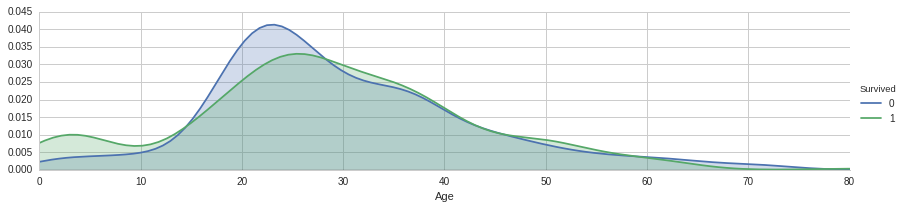

In [13]:
if visualize_data:
    titanic_plotting.plot_age_survival_distribution(titanic_df)

In [14]:
test_df = titanic_feature_creation.make_family_size_feature(test_df)
titanic_df = titanic_feature_creation.make_family_size_feature(titanic_df)

In [15]:
# define training and testing sets

X_train = titanic_df.drop(["Survived"],axis=1)
Y_train = titanic_df["Survived"]
X_test  = test_df.drop(["PassengerId"],axis=1).copy()

# Feature Transformation

X_train,X_test,scaler = titanic_feature_transformation.min_max_scaling(X_train,X_test)

#X_train,X_test = titanic_feature_transformation.transform_features_by_pca(X_train,X_test)

score equals 0.809428
{'min_impurity_split': 0.35, 'min_weight_fraction_leaf': 0.0125, 'criterion': 'gini', 'min_samples_leaf': 20}
accuracy on training data = 0.840628507295


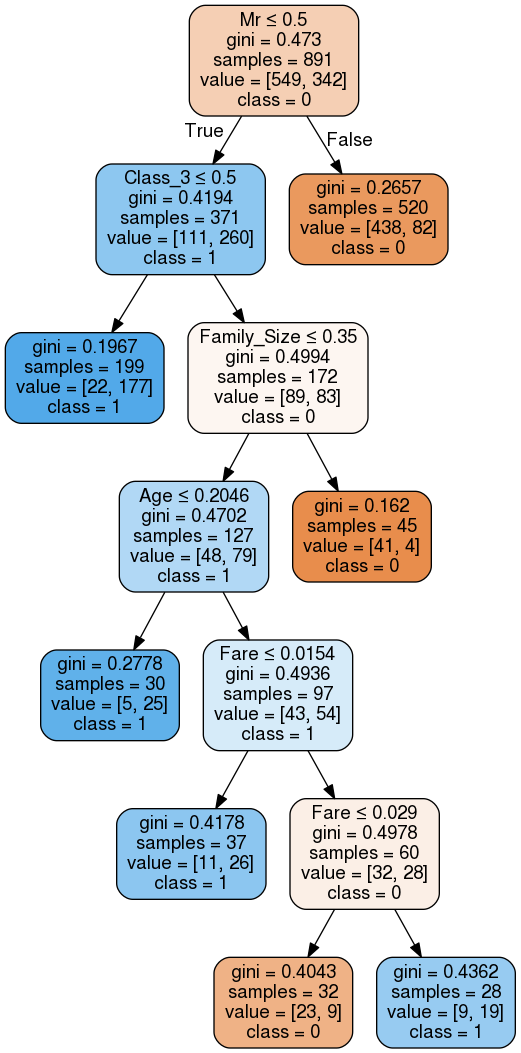

In [16]:
parameters = {'min_samples_leaf':[20],'min_weight_fraction_leaf':[0.0125], 'criterion':['gini'], 'min_impurity_split':[1.5e-1,2.5e-1,3.5e-1]}

dtc = titanic_classifiers.create_decision_tree_classifier(X_train,Y_train,parameters)


viz_tree = titanic_plotting.visualize_decision_tree_and_write_to_file(dtc,X_train.columns,"01","Decision_Tree_Classifier.pdf")
from IPython.display import Image
Image(viz_tree.create_png())

#print titanic_df[(titanic_df['Mr'] == 1) & (titanic_df['Survived'] == 1)]

In [ ]:
from sklearn.ensemble import RandomForestClassifier

parameters = {'min_samples_leaf':[5],'min_weight_fraction_leaf':[0.0125], 'n_estimators':[25,30,35], 'min_impurity_split':[1.5e-1], 'criterion':['gini']}

random_forest = titanic_classifiers.create_random_forest_classifier(X_train,Y_train,parameters)

print random_forest.feature_importances_
print X_train.columns

Y_pred_rf = random_forest.predict_proba(X_test)[:,1]


In [ ]:
from sklearn.svm import SVC

parameters = {"C":[1.5,1.75,2], "kernel":['rbf'], "gamma":[6.5e-1]}

svc = titanic_classifiers.create_support_vector_machine_classifier(X_train,Y_train,parameters)

Y_pred_svc = svc.predict(X_test)

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

parameters = {"C":[60],"kernel":['rbf'],'gamma':[2.5e-2]}
svc_base = titanic_classifiers.create_support_vector_machine_classifier(X_train,Y_train,parameters)

X_train['Base_Prediction'] = svc_base.predict(X_train)
X_test['Base_Prediction'] = svc_base.predict(X_test)
X_train['Survived'] = Y_train

X_train_0 = X_train[X_train['Base_Prediction'] == 0]
X_train_1 = X_train[X_train['Base_Prediction'] == 1]

print len(X_train_0)
print len(X_train_1)

print len(X_train)

Y_train_0 = X_train_0['Survived']
Y_train_1 = X_train_1['Survived']

parameters = {"C":[100,1000,10000]}

svc_0 = titanic_classifiers.create_logistic_regression_classifier(X_train_0.drop(['Base_Prediction','Survived'],axis=1),Y_train_0,parameters)
svc_1 = titanic_classifiers.create_logistic_regression_classifier(X_train_1.drop(['Base_Prediction','Survived'],axis=1),Y_train_1,parameters)

X_train['0_Prediction'] = svc_0.predict(X_train.drop(['Base_Prediction','Survived'],axis=1))
X_train['1_Prediction'] = svc_1.predict(X_train.drop(['0_Prediction','Base_Prediction','Survived'],axis=1))

X_test['0_Prediction'] = svc_0.predict(X_test.drop(['Base_Prediction'],axis=1))
X_test['1_Prediction'] = svc_1.predict(X_test.drop(['0_Prediction','Base_Prediction'],axis=1))

X_train['Final_Prediction'] = X_train['Base_Prediction']
X_test['Final_Prediction'] = X_test['Base_Prediction']

print len(X_train[((X_train['Base_Prediction'] == 0) & (X_train['0_Prediction'] == 1))])
print len(X_train[((X_train['Base_Prediction'] == 1) & (X_train['1_Prediction'] == 0))])

X_train.loc[((X_train['Base_Prediction'] == 0) & (X_train['0_Prediction'] == 0)),"Final_Prediction"] = 0
X_train.loc[((X_train['Base_Prediction'] == 0) & (X_train['0_Prediction'] == 1)),"Final_Prediction"] = 1
X_train.loc[((X_train['Base_Prediction'] == 1) & (X_train['1_Prediction'] == 0)),"Final_Prediction"] = 0
X_train.loc[((X_train['Base_Prediction'] == 1) & (X_train['1_Prediction'] == 1)),"Final_Prediction"] = 1

X_test.loc[((X_test['Base_Prediction'] == 0) & (X_test['0_Prediction'] == 0)),"Final_Prediction"] = 0
X_test.loc[((X_test['Base_Prediction'] == 0) & (X_test['0_Prediction'] == 1)),"Final_Prediction"] = 1
X_test.loc[((X_test['Base_Prediction'] == 1) & (X_test['1_Prediction'] == 0)),"Final_Prediction"] = 0
X_test.loc[((X_test['Base_Prediction'] == 1) & (X_test['1_Prediction'] == 1)),"Final_Prediction"] = 1

Y_pred_dt_svc = X_test['Final_Prediction']

training_accuracy = float(len(X_train[X_train['Final_Prediction'] == X_train['Survived']]))/len(X_train)

print training_accuracy

X_train = X_train.drop(['0_Prediction','1_Prediction','Base_Prediction','Final_Prediction','Survived'],axis=1)
X_test = X_test.drop(['0_Prediction','1_Prediction','Base_Prediction','Final_Prediction'],axis=1)



In [ ]:
from sklearn.linear_model import LogisticRegression

parameters = {'C':[20.]}

log_reg_clf_base = titanic_classifiers.create_logistic_regression_classifier(X_train,Y_train,parameters)

print log_reg_clf_base.coef_

X_train['Base_Prediction'] = log_reg_clf_base.predict(X_train)
X_test['Base_Prediction'] = log_reg_clf_base.predict(X_test)
X_train['Survived'] = Y_train

X_train_0 = X_train[X_train['Base_Prediction'] == 0]
X_train_1 = X_train[X_train['Base_Prediction'] == 1]

Y_train_0 = X_train_0['Survived']
Y_train_1 = X_train_1['Survived']

parameters = {"max_depth":[4]}

log_reg_clf_0 = titanic_classifiers.create_random_forest_classifier(X_train_0.drop(['Base_Prediction','Survived'],axis=1),Y_train_0,parameters)
log_reg_clf_1 = titanic_classifiers.create_random_forest_classifier(X_train_1.drop(['Base_Prediction','Survived'],axis=1),Y_train_1,parameters)

X_train['0_Prediction'] = log_reg_clf_0.predict(X_train.drop(['Base_Prediction','Survived'],axis=1))
X_train['1_Prediction'] = log_reg_clf_1.predict(X_train.drop(['0_Prediction','Base_Prediction','Survived'],axis=1))

X_test['0_Prediction'] = log_reg_clf_0.predict(X_test.drop(['Base_Prediction'],axis=1))
X_test['1_Prediction'] = log_reg_clf_1.predict(X_test.drop(['0_Prediction','Base_Prediction'],axis=1))

X_train['Final_Prediction'] = X_train['Base_Prediction']
X_test['Final_Prediction'] = X_test['Base_Prediction']

print len(X_train[((X_train['Base_Prediction'] == 0) & (X_train['0_Prediction'] == 1))])
print len(X_train[((X_train['Base_Prediction'] == 1) & (X_train['1_Prediction'] == 0))])

print len(X_test[((X_train['Base_Prediction'] == 0) & (X_train['0_Prediction'] == 1))])
print len(X_test[((X_train['Base_Prediction'] == 1) & (X_train['1_Prediction'] == 0))])

X_train.loc[((X_train['Base_Prediction'] == 0) & (X_train['0_Prediction'] == 0)),"Final_Prediction"] = 0
X_train.loc[((X_train['Base_Prediction'] == 0) & (X_train['0_Prediction'] == 1)),"Final_Prediction"] = 1
X_train.loc[((X_train['Base_Prediction'] == 1) & (X_train['1_Prediction'] == 0)),"Final_Prediction"] = 0
X_train.loc[((X_train['Base_Prediction'] == 1) & (X_train['1_Prediction'] == 1)),"Final_Prediction"] = 1

X_test.loc[((X_test['Base_Prediction'] == 0) & (X_test['0_Prediction'] == 0)),"Final_Prediction"] = 0
X_test.loc[((X_test['Base_Prediction'] == 0) & (X_test['0_Prediction'] == 1)),"Final_Prediction"] = 1
X_test.loc[((X_test['Base_Prediction'] == 1) & (X_test['1_Prediction'] == 0)),"Final_Prediction"] = 0
X_test.loc[((X_test['Base_Prediction'] == 1) & (X_test['1_Prediction'] == 1)),"Final_Prediction"] = 1

Y_pred_dt_log_reg = X_test['Final_Prediction']

training_accuracy = float(len(X_train[X_train['Final_Prediction'] == X_train['Survived']]))/len(X_train)

print training_accuracy

X_train = X_train.drop(['0_Prediction','1_Prediction','Base_Prediction','Final_Prediction','Survived'],axis=1)
X_test = X_test.drop(['0_Prediction','1_Prediction','Base_Prediction','Final_Prediction'],axis=1)



In [ ]:
from sklearn.linear_model import LogisticRegression

parameters = {'C':[4,5,6]}

log_reg_clf = titanic_classifiers.create_logistic_regression_classifier(X_train,Y_train,parameters)

Y_pred_log_reg = log_reg_clf.predict(X_test)

score equals 0.818687
{'kernel': 'linear', 'C': 3.25, 'probability': True, 'gamma': 0.45}
0.832772166105
[[-0.2578678  -2.04937625 -0.79933721  1.94451225  0.         -0.65602317
  -0.54646236  2.05694416  0.11671577 -0.62019581  0.05868941  0.03327832
  -0.09196773  1.88750807  0.08495864  0.03355072 -0.11850937  0.12450664
  -0.47548522 -2.35890449]]
Index([u'Age', u'SibSp', u'Parch', u'Fare', u'Mil', u'Rev', u'Dr', u'Master',
       u'Mrs', u'Mr', u'C', u'Q', u'S', u'female', u'Class_1', u'Class_2',
       u'Class_3', u'Young_Miss', u'Old_Miss', u'Family_Size'],
      dtype='object')
[ True  True  True  True False  True  True  True  True  True False False
  True  True  True False  True  True  True  True]
Optimal number of features : 16


/home/kyle/anaconda2/lib/python2.7/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


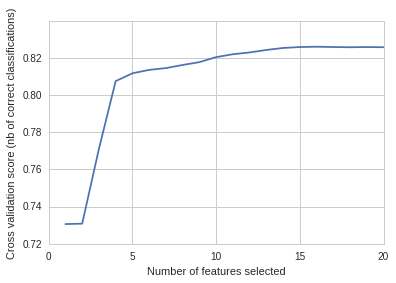

score equals 0.820875
{'C': 3.5, 'probability': True, 'gamma': 0.5}
0.843995510662


In [17]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import StratifiedShuffleSplit

#kbest = SelectKBest(chi2, k=15)

#X_reduced_train = kbest.fit_transform(X_train, Y_train)
#X_reduced_test = kbest.transform(X_test)

#parameters = {'C':[3,3.5,4]}

parameters = {"C":[3.25,3.5,3.75], "kernel":['linear'], "gamma":[0.45,0.5,0.55],'probability':[True]}

lin_svc_clf = titanic_classifiers.create_support_vector_machine_classifier(X_train,Y_train,parameters)

print lin_svc_clf.coef_
print X_train.columns

rfecv = RFECV(estimator=lin_svc_clf, step=1, cv=StratifiedShuffleSplit(n_splits=40, test_size = 0.5, random_state=472),scoring='accuracy')
rfecv = rfecv.fit(X_train, Y_train)

print rfecv.support_

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

X_reduced_train = rfecv.transform(X_train)
X_reduced_test = rfecv.transform(X_test)

parameters = {"C":[3.5,3.75,4.0],'gamma':[5e-1,1,2],'probability':[True]}

lin_svc_clf = titanic_classifiers.create_support_vector_machine_classifier(X_reduced_train,Y_train,parameters)

Y_pred_lin_svc = lin_svc_clf.predict_proba(X_reduced_test)[1]


In [29]:
parameters = {"C":[2.5,2.75,3.0],'gamma':[3.5e-1,4.0e-1,4.5e-1],'probability':[True]}

lin_svc_clf = titanic_classifiers.create_support_vector_machine_classifier(X_reduced_train,Y_train,parameters)

Y_pred_lin_svc = lin_svc_clf.predict_proba(X_reduced_test)[:,1]

score equals 0.822391
{'C': 2.75, 'probability': True, 'gamma': 0.45}
0.837261503928


In [ ]:
parameters = {'C':[2.5,3.0,3.5]}

log_reg_clf = titanic_classifiers.create_logistic_regression_classifier(X_reduced_train,Y_train,parameters)

Y_pred_log_reg = log_reg_clf.predict_proba(X_reduced_test)[:,1]


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

parameters = {'learning_rate':[0.1], 'n_estimators':[35],'min_weight_fraction_leaf':[0.08],'max_depth':[None],'min_impurity_split':[0.075]}

gbc = titanic_classifiers.create_gradient_boosted_classifier(X_train,Y_train,parameters)

Y_pred_gb = gbc.predict(X_test)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

parameters = {"n_estimators":[500],"learning_rate":[0.01]}

adbc = titanic_classifiers.create_adaboost_classifier(X_train,Y_train,parameters)

Y_pred_adbc = adbc.predict(X_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

parameters = {'n_neighbors':[13],'weights':['uniform']}

knn = titanic_classifiers.create_knn_classifier(X_train,Y_train,parameters)

Y_pred_knn = knn.predict(X_test)

In [ ]:
import xgboost as xgb

from sklearn.model_selection import GridSearchCV

xgb_clf = titanic_xgb_classifiers.create_optimum_xgb_classifier(X_train,Y_train)

Y_pred_xgb = xgb_clf.predict_proba(X_test)[:,1]

In [30]:
# put ensemble together
#total_score = knn_score + rf_score + svc_score + logreg_score

#Y_pred_avg = (1./6.) * Y_pred_rf + (1./2.) * Y_pred_lin_svc + (1./6.) * Y_pred_log_reg + (1./6.) * Y_pred_xgb
#Y_pred_avg = Y_pred_rf
Y_pred_avg = Y_pred_svc
#Y_pred_avg = Y_pred_lin_svc
#Y_pred_avg = Y_pred_knn
#Y_pred_avg = Y_pred_adbc
#Y_pred_avg = Y_pred_gb
#Y_pred_avg = Y_pred_xgb
#Y_pred_avg = Y_pred_dt_svc
#Y_pred_avg = Y_pred_dt_log_reg
#Y_pred_avg = Y_pred_log_reg
Y_pred = list(map(lambda x: 0 if x < 0.5 else 1, Y_pred_avg))

In [31]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)